Tutorial 2: Brightness Adaption
===============================

In the previous tutorial we motivated a need to adapt our _Pixelization_to the source's morphology, such that source
pixels congregates in the source's brightest regions regardless of where it is located in the source-plane. This
raises an interesting question; how do we adapt our source _Pixelization_to the reconstructed source, before we've
actually reconstructed the source and therefore know what to adapt it too?

To do this, we define a 'hyper-galaxy-image' of the lensed source galaxy. This is a model image of the source
computed using a previous lens model fit to the image (e.g. in an earlier phase of a pipeline). This image tells us
where in the image our source is located, thus telling us where we need to adapt our source pixelization!

So, lets go into the details of how this works. We'll use the same compact source galaxy as the previous tutorial
and we'll begin by fitting it with a magnification based _Pixelization_. Why? So we can use its model image to set up
the hyper-galaxy-image.

In [1]:
%matplotlib inline

import autolens as al
import autolens.plot as aplt
from pyprojroot import here

workspace_path = str(here())
print("Workspace Path: ", workspace_path)

Workspace Path:  /home/carlos/autolens_workspace


We'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's _MassProfile_ is an _EllipticalIsothermal_.
 - The source galaxy's _LightProfile_ is an _EllipticalSersic_.

In [2]:
from howtolens.simulators.chapter_5 import lens_sie__source_sersic

dataset_type = "chapter_5"
dataset_name = "lens_sie__source_sersic"
dataset_path = f"{workspace_path}/howtolens/dataset/{dataset_type}/{dataset_name}"

imaging = al.Imaging.from_fits(
    image_path=f"{dataset_path}/image.fits",
    noise_map_path=f"{dataset_path}/noise_map.fits",
    psf_path=f"{dataset_path}/psf.fits",
    pixel_scales=0.1,
)

mask = al.Mask.circular(
    shape_2d=imaging.shape_2d, pixel_scales=imaging.pixel_scales, sub_size=2, radius=3.0
)

masked_imaging = al.MaskedImaging(imaging=imaging, mask=mask)

Next, we're going to fit the image using our magnification based grid. The code below does all the usual steps 
required to do this.

In [3]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.111111, 0.0), einstein_radius=1.6
    ),
)

source_galaxy_magnification = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiMagnification(shape=(30, 30)),
    regularization=al.reg.Constant(coefficient=3.3),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy_magnification])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

Lets have a quick look to make sure it has the same residuals we saw in tutorial 1.

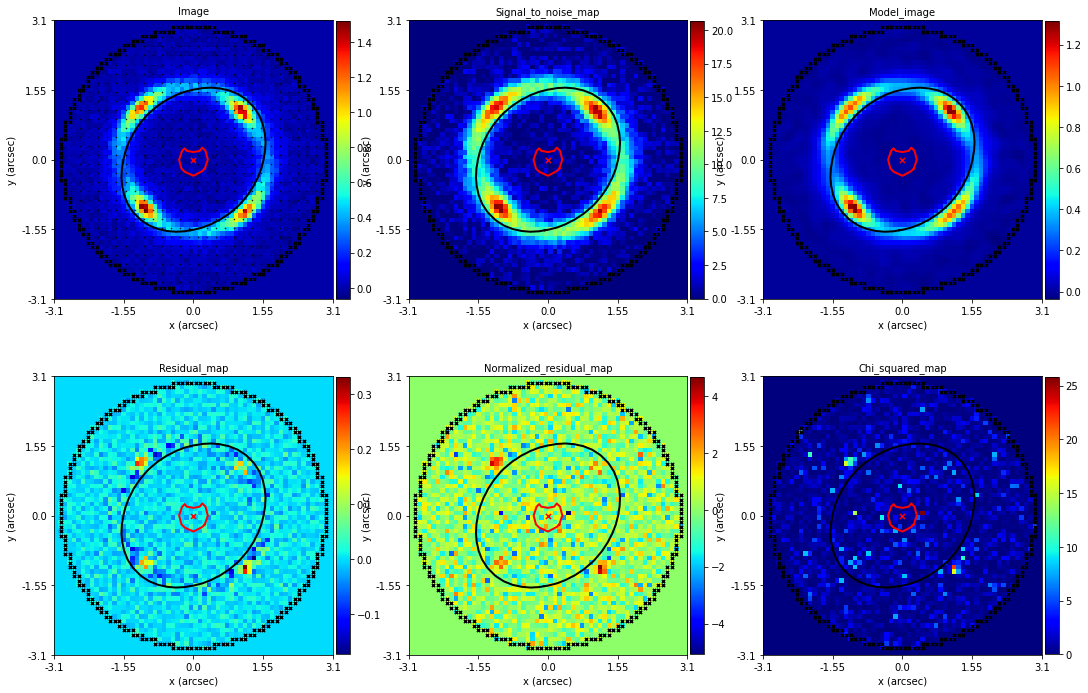

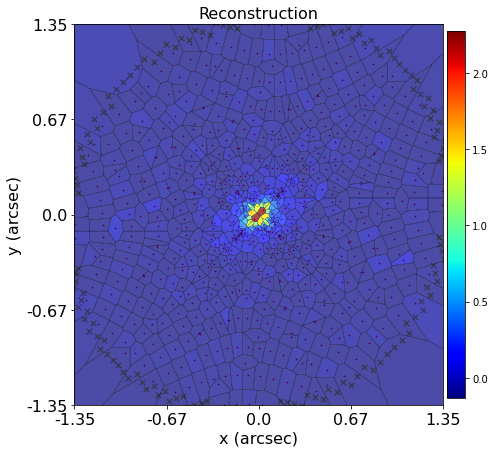

In [4]:
aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

Finally, we can use this fit to set up our hyper-galaxy-image. This hyper-galaxy-image isn't perfect, as there are 
residuals in the central regions of the reconstructed source. But it's *okay* and it'll certainly give us enough 
information on where the lensed source is located to adapt our _Pixelization_.

(The 'in_1d_binned' ensures our hyper-image is at the native resolution of our _Imaging_ data, as opposed to a 
higher resolution sub-grid).

In [5]:
hyper_image = fit.model_image.in_1d_binned

Now lets take a look at brightness based adaption in action! Below, we define a source-galaxy using our new 
_VoronoiBrightnessImage_ _Pixelization_and use this to fit the lens-data. 

We also attach the hyper_galaxy_image to this galaxy, because the _Pixelization_ uses this hyper_galaxy_image for 
adaption, the galaxy needs to know what hyper-galaxy-image it uses to adapt its _Pixelization_ too!

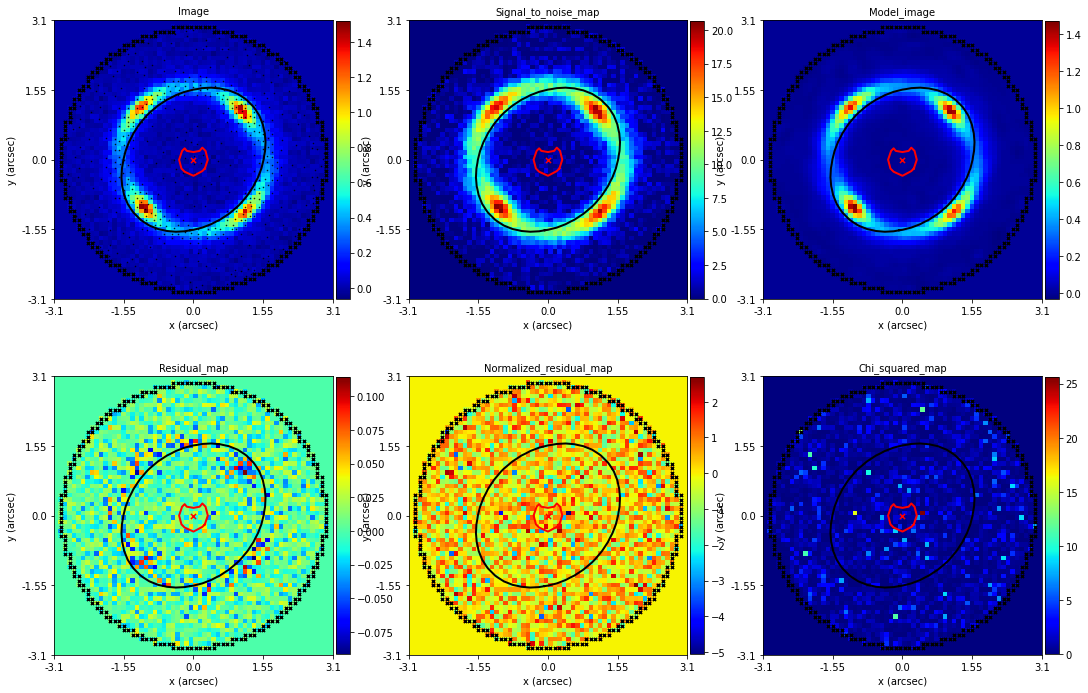

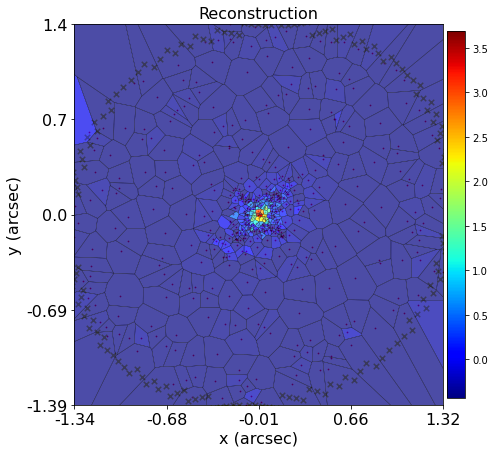

In [6]:
source_galaxy_brightness = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=10.0
    ),
    regularization=al.reg.Constant(coefficient=0.5),
    hyper_galaxy_image=hyper_image,
    binned_hyper_galaxy_image=hyper_image,
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy_brightness])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.FitImaging.subplot_fit_imaging(
    fit=fit, include=aplt.Include(inversion_image_pixelization_grid=True, mask=True)
)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

Would you look at that! Our reconstruction of the image no longer has residuals! By congregating more source 
pixels in the brightest regions of the source reconstruction we get a better fit. Furthermore, we can check that 
this provides an increase in Bayesian log evidence, noting that the log evidence of the compact source when using a 
VoronoiMagnification _Pixelization_was 4216:

In [7]:
print("Evidence using magnification based _Pixelization_= ", 4216)
print("Evidence using brightness based _Pixelization_= ", fit.log_evidence)

Evidence using magnification based _Pixelization_=  4216
Evidence using brightness based _Pixelization_=  5472.93954549169


It increases! By over 200, which, for a Bayesian log evidence, is pretty damn large! By any measure, this 
_Pixelization_ is a huge success. It turns out that we should have been adapting to the source's brightness all along! 
In doing so, we will *always* reconstruct the detailed structure of the source's brightest regions with a sufficiently 
high resolution. Hurrah!

So, we are now able to adapt our _Pixelization_to the morphology of our lensed source galaxy. To my knowledge, this 
is the *best* approach one can take in lens modeling. Its more tricky to implement (as I'll explain next) and 
introduces extra non-linear parameters. But the pay-off is more than worth it, as we fit our data better and 
end up using far fewer source pixels to fit the data because we don't 'waste' pixels reconstructing regions of the 
source-plane where there is no signal.

Okay, so how does the hyper_image actually adapt our _Pixelization_to the source's brightness? It uses a 'weighted 
KMeans clustering algorithm', which is a standard algorithm for partioning data in statistics.

In simple terms, this algorithm works as follows:

    1) Give the KMeans algorithm a set of weighted data (e.g. determined from the hyper-galaxy image).
    
    2) For a given number of K-clusters, this algorithm will find a set of (y,x) coordinates that equally partition 
       the weighted data-set. Wherever the data has higher weighting, more clusters congregate and visa versa.
    
    3) The returned (y,x) 'clusters' then make up our source-pixel centres, where the brightest (e.g. higher weighted 
       regions of the hyper-galaxy-image will have more clusters! Like we did for the magnification based 
       _Pixelization_, we can then trace these coordinates to the source-plane to define our source-pixel _Pixelization_.

This is a fairly simplistic description of a KMeans algorithm. Feel free to check out the links below for a more 
in-depth view:

    https://en.wikipedia.org/wiki/K-means_clustering
    https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html


Okay, so we now have a sense of how our VoronoiBrightnessImage _Pixelization_is computed. Now, lets look at how we 
create the weighted data the KMeans algorithm uses.

This image, called the 'cluster_weight_map' is generated using the 'weight_floor' and 'weight_power' parameters of 
the VoronoiBrightness _Pixelization_. The cluster weight map is generated following 4 steps:

    1) Increase all values of the hyper-galaxy-image that are < 0.02 to 0.02. This is necessary because negative 
       values and zeros break the KMeans clustering algorithm.
    
    2) Divide all values of this image by its maximum value, such that the hyper-galaxy-image now only contains values 
       between 0.0 and 1.0 (where the values of 1.0 were the maximum values of the hyper-galaxy-image).
    
    3) Add the weight_floor to all values (a weight_floor of 0.0 therefore does not change the cluster weight map).
    
    4) Raise all values to the power of weight_power (a weight_power of 1.0 therefore does not change the cluster 
       weight map, whereas a value of 0.0 means all values 1.0 and therefore weighted equally).

Lets look at this in action. We'll inspect 3 cluster_weight_maps, using a weight_power of 0.0, 5.0 and 10.0, 
setting the weight_floor to 0.0 such that it does not change the cluster weight map.

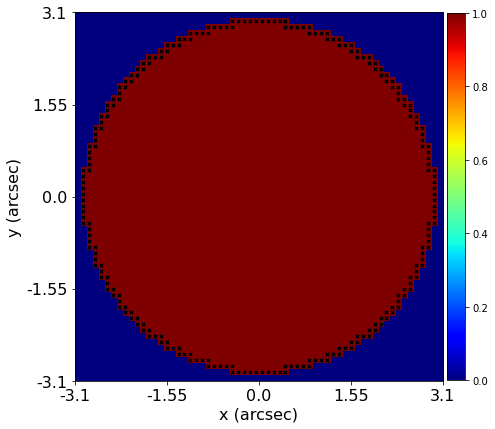

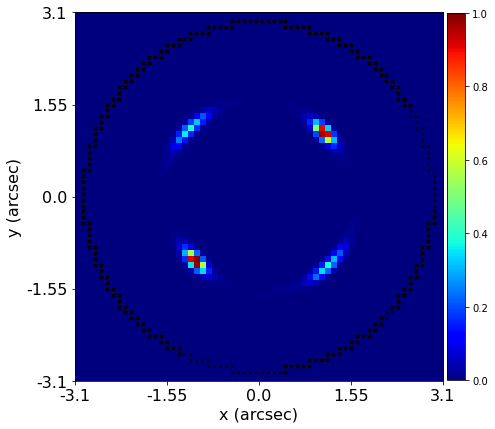

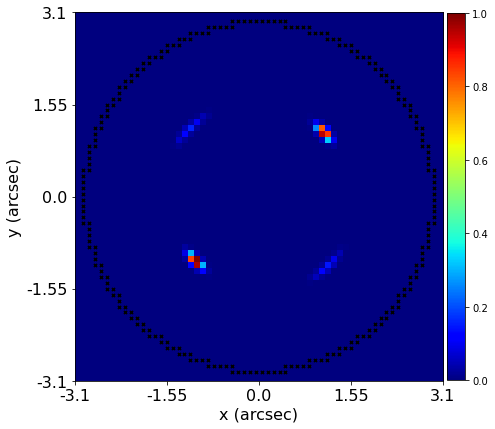

In [10]:
source_weight_power_0 = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=0.0
    ),
    regularization=al.reg.Constant(coefficient=1.0),
    hyper_galaxy_image=hyper_image,
    binned_hyper_galaxy_image=hyper_image,
)

cluster_weight_power_0 = source_weight_power_0.pixelization.weight_map_from_hyper_image(
    hyper_image=source_weight_power_0.hyper_galaxy_image
)

aplt.Array(array=cluster_weight_power_0, mask=mask)

source_weight_power_5 = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=5.0
    ),
    regularization=al.reg.Constant(coefficient=1.0),
    hyper_galaxy_image=hyper_image,
    binned_hyper_galaxy_image=hyper_image,
)

cluster_weight_power_5 = source_weight_power_5.pixelization.weight_map_from_hyper_image(
    hyper_image=source_weight_power_5.hyper_galaxy_image
)

aplt.Array(array=cluster_weight_power_5, mask=mask)

source_weight_power_10 = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.0, weight_power=10.0
    ),
    regularization=al.reg.Constant(coefficient=1.0),
    hyper_galaxy_image=hyper_image,
    binned_hyper_galaxy_image=hyper_image,
)

cluster_weight_power_10 = source_weight_power_10.pixelization.weight_map_from_hyper_image(
    hyper_image=source_weight_power_10.hyper_galaxy_image
)

aplt.Array(array=cluster_weight_power_10, mask=mask)

When we increase the weight-power the brightest regions of the hyper-galaxy-image become weighted higher relative 
to the fainter regions. This means that t e KMeans algorithm will adapt its _Pixelization_to the brightest regions of 
the source.

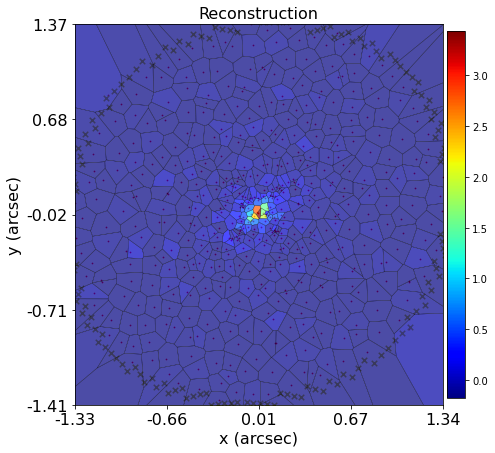

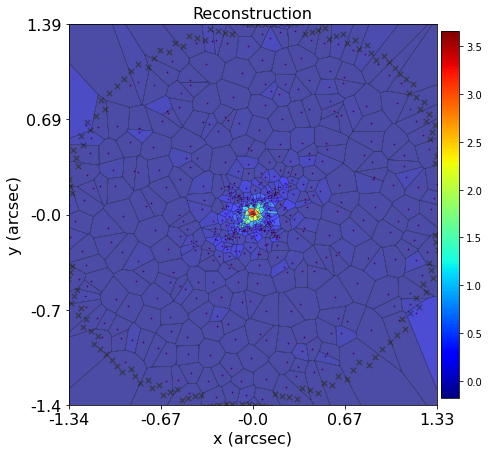

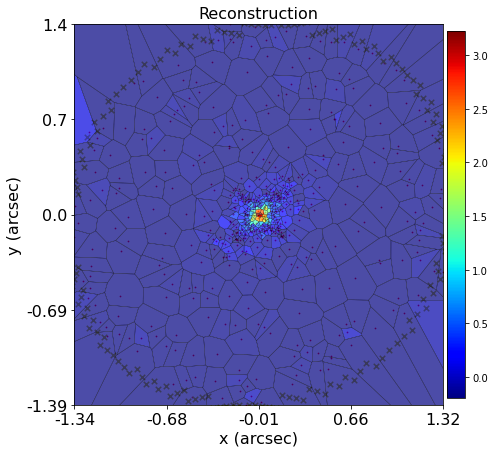

In [11]:
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_weight_power_0])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_weight_power_5])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_weight_power_10])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

So, what does the weight_floor do? Increasing the weight-power congregates pixels around the source. However, there 
is a risk that by congregating too many source pixels in its brightest regions we lose resolution further out, where 
the source is bright, but not its brightest!

The noise-floor allows these regions to maintain a higher weighting whilst the noise_power increases. This means that 
the _Pixelization_can fully adapt to the source's brightest and faintest regions simultaneously.

Lets look at once example:

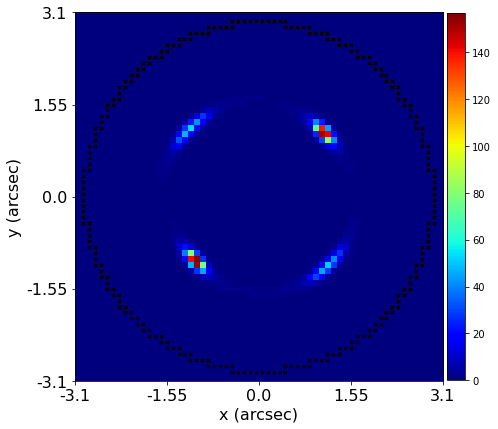

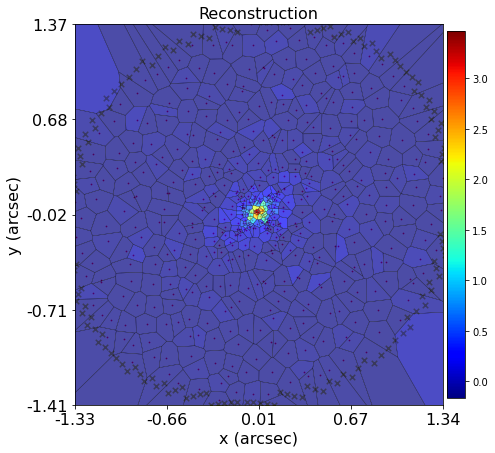

In [12]:
source_weight_floor = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.VoronoiBrightnessImage(
        pixels=500, weight_floor=0.5, weight_power=10.0
    ),
    regularization=al.reg.Constant(coefficient=1.0),
    hyper_galaxy_image=hyper_image,
)

cluster_weight_floor = source_weight_floor.pixelization.weight_map_from_hyper_image(
    hyper_image=source_weight_floor.hyper_galaxy_image
)

aplt.Array(array=cluster_weight_floor, mask=mask)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_weight_floor])

fit = al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)

aplt.Inversion.reconstruction(
    inversion=fit.inversion, include=aplt.Include(inversion_pixelization_grid=True)
)

To end, lets think about the Bayesian log evidence which goes to significantly higher values than a magnification-based 
grid. At this point, it might be worth reminding yourself how the Bayesian log evidence works by going back to the 
'introduction' text file.

So, why do you think why adapting to the source's brightness increases the log evidence?

It is because by adapting to the source's morphology we can now access solutions that fit the data really well 
(e.g. to the Gaussian noise-limit) but use significantly fewer source-pixels than other al. For instance, a typical 
magnification based _Grid_ uses resolutions of 40 x 40, or 1600 pixels. In contrast, a morphology based _Grid_ typically 
uses just 300-800 pixels (depending on the source itself). Clearly, the easiest way to make our source solution simpler 
is to use fewer pixels overall!

This provides a second benefit. If the best solutions in our fit want to use the fewest source-pixels possible and 
PyAutoLens can now access those solutions, this means that hyper-galaxy-mode will run much faster than the magnification 
based grid! Put simply, fewer source-pixels means lower computational overheads. YAY!

Tutorial 2 done, next up, adaptive regularization!